# Мультиклассовая классификация с помощью метода опорных векторов

Содержание практической работы:

- функция потерь для метода опорных векторов
- аналитический градиент
- его проверка с помощью численного градиента
- подбор скорости обучения и степени регуляризации на проверочной выборке
- оптимизация функции потерь с помощью стохастического градиентного спуска
- визуализация конечных весов

Статья о [Multi-class SVM Loss](https://www.pyimagesearch.com/2016/09/05/multi-class-svm-loss/) [eng]

In [1]:
# Подключим основные библиотеки
from __future__ import print_function

import math
import random
import time
from builtins import object, range

import matplotlib.pyplot as plt
import numpy as np
from past.builtins import xrange

from random import randrange

%matplotlib inline

## Загрузка базы CIFAR-10

In [2]:
# # Определим функции для загрузки базы CIFAR-10

# from six.moves import cPickle as pickle
# import os
# import platform

# def load_pickle(f):
#     version = platform.python_version_tuple()
#     if version[0] == '2':
#         return  pickle.load(f)
#     elif version[0] == '3':
#         return  pickle.load(f, encoding='latin1')
#     raise ValueError("Неверная версия Python: {}".format(version))

# def load_CIFAR_batch(filename):
#     with open(filename, 'rb') as f:
#         datadict = load_pickle(f)
#         X = datadict['data']
#         Y = datadict['labels']
#         X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
#         Y = np.array(Y)
#         return X, Y

# def load_CIFAR10(ROOT):
#     xs = []
#     ys = []
#     for b in range(1,6):
#         f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
#         X, Y = load_CIFAR_batch(f)
#         xs.append(X)
#         ys.append(Y)
#     Xtr = np.concatenate(xs)
#     Ytr = np.concatenate(ys)
#     del X, Y
#     Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
#     return Xtr, Ytr, Xte, Yte

In [3]:
# # путь до папки с базой
# cifar10_dir = '...'

# # Сброс переменных для избежания многократной загрузки базы в память
# try:
#     del X_train, y_train
#     del X_test, y_test
#     print('Стираем ранее загруженные данные.')
# except:
#     pass

# X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# print('Размерность изображений для обучения: ', X_train.shape)
# print('Размерность классов для обучения: ', y_train.shape)
# print('Размерность изображений для тестирования: ', X_test.shape)
# print('Размерность классов для тестирования: ', y_test.shape)

In [4]:
from keras.datasets import cifar10
# Необходимо загрузить изображения CIFAR-10 в память:
# изображения_обучение, классы_обучение, изображения_тест, классы_тест

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

def procces_y_data(y):
    y_true = y
    y_ok =[]
    for i in range(len(y_true)):
        y_ok.append(y_true[i][0])
    return np.array(y_ok)

y_train = procces_y_data(y_train)
y_test = procces_y_data(y_test)

print(f'Размер данных обучающей выборки: {X_train.shape}')
print(f'Размер разметки обучающей выборки: {y_train.shape}')
print(f'Совпадает ли размер данных обучающей выборки с размером разметки обучающей выборки : \
{X_train.shape[0] == y_train.shape[0]}')
print(f'Размер данных тестовой выборки: {X_test.shape}')
print(f'Размер разметки тестовой выборки: {y_test.shape}')
print(f'Совпадает ли размер данных тестовой выборки с размером разметки тестовой выборки : \
{X_test.shape[0] == y_test.shape[0]}')

print(f'Всего изображений: {X_train.shape[0] + X_test.shape[0]}')

Using TensorFlow backend.


Размер данных обучающей выборки: (50000, 32, 32, 3)
Размер разметки обучающей выборки: (50000,)
Совпадает ли размер данных обучающей выборки с размером разметки обучающей выборки : True
Размер данных тестовой выборки: (10000, 32, 32, 3)
Размер разметки тестовой выборки: (10000,)
Совпадает ли размер данных тестовой выборки с размером разметки тестовой выборки : True
Всего изображений: 60000


## Визуализация классов и примеров

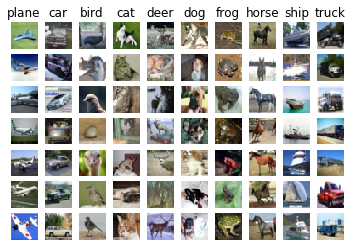

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Напишите комментарии к коду ниже, что он делает и для чего это нужно.

In [6]:
# *** ваш комментарий ***
# Задаем численные параметры мозностей обучающей, валидационной, тестовой 
#и проверочной(для проверки работы алгоритма) выборок
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# *** ваш комментарий ***
# Формируем массив значений от 49000 до 50000 (num_training + num_validation) num_validation -
# - будующие индексы изображений к обучению (1000 изображений из 50к)
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# *** ваш комментарий ***
# Формируем массив значений от 0 до 49000(num_training) -
# - будующие индексы изображений к обучению (49000 изображений из 50к)
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# *** ваш комментарий ***
# 500 любых изображений из тренировочной выборки. Для проверки работы алгоритмы не на всей обучающей выборке
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# *** ваш комментарий ***
# Формируем массив значений от 0 до 1000 (num_test). (1000 изображений из 10000)
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность классов для обучения: ', y_train.shape)
print('Размерность изображений для проверки: ', X_val.shape)
print('Размерность классов для проверки: ', y_val.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность классов для тестирования: ', y_test.shape)

Размерность изображений для обучения:  (49000, 32, 32, 3)
Размерность классов для обучения:  (49000,)
Размерность изображений для проверки:  (1000, 32, 32, 3)
Размерность классов для проверки:  (1000,)
Размерность изображений для тестирования:  (1000, 32, 32, 3)
Размерность классов для тестирования:  (1000,)


In [7]:
# *** ваш комментарий ***
# приводим размерность картинок размером 32х32х3 в плоский вид (кол-во элементов выборки,3072)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность изображений для проверки: ', X_val.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность изображений для разрабоки: ', X_dev.shape)

Размерность изображений для обучения:  (49000, 3072)
Размерность изображений для проверки:  (1000, 3072)
Размерность изображений для тестирования:  (1000, 3072)
Размерность изображений для разрабоки:  (500, 3072)


## Первичная обработка данных

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


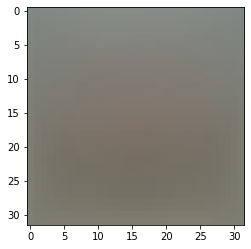

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# *** ваш комментарий ***
# поиск "среднего изображения" для дальнейшей централизации данных
mean_image = np.mean(X_train, axis=0)
mean_image = mean_image.astype('float64')
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()

# *** ваш комментарий ***
# Централизация данных для уплотнения прос-ва признаков (позволяет гадиентам не "вылетать")
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# *** ваш комментарий ***
# bias trick - нужен для одновременного обучения весов и bias(константы смещения)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM классификатор

In [37]:
def svm_loss_naive(W, X, y, reg):
    dW = np.zeros(W.shape)

#     num_classes = W.shape[1]
#     num_train = X.shape[0]
#     loss = 0.0
#     for i in range(num_train):
#         scores = X[i].dot(W)
#         correct_class_score = scores[y[i]]
#         for j in range(num_classes):
#             if j == y[i]:
#                 continue
#             margin = scores[j] - correct_class_score + 1 # note delta = 1
#             if margin > 0:
#                 loss += margin

#     loss /= num_train

#     loss += reg * np.sum(W * W)

    # Задание: дописать код для расчета градиента функции потерь и записать его в dW.
    # Будет проще считать производную функции одновременно с потерями.
    # Чтобы это реализовать необходимо изменить код и выше.

    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        curr = X[i]
        yi = y[i]
        scores = curr.dot(W)
        correct_class_score = scores[yi]
        for j in range(num_classes):
            if j == yi:
                continue
            margin = scores[j] - correct_class_score
            if margin > 0:
                loss += margin
                dW[:,j] += curr
                dW[:,yi] -= curr

    loss /= num_train
    dW /= num_train

    loss += reg * np.sum(W * W)
    dW += reg * W
    # ***Конец вашего кода***
    
    return loss, dW

In [38]:
#Функция для проверки градиента

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h
        fxph = f(x)
        x[ix] = oldval - h
        fxmh = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('Численный: %f аналитический: %f, относительная погрешность: %e'
              %(grad_numerical, grad_analytic, rel_error))

In [39]:
# Инициализация весов
W = np.random.randn(3073, 10) * 0.0001

# Расчет потерь и градиента
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Численно рассчитайте градиент по нескольким случайно выбранным измерениям и сравните их с аналитическим градиентом.
# Значения должны быть практически идентичны по любому из измерений.
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Еще раз, но уже с регуляризацией
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Численный: 7.716165 аналитический: 7.669974, относительная погрешность: 3.002125e-03
Численный: -11.272618 аналитический: -11.272618, относительная погрешность: 3.929218e-12
Численный: -4.473931 аналитический: -4.473931, относительная погрешность: 8.148875e-12
Численный: 1.537486 аналитический: 1.484061, относительная погрешность: 1.768139e-02
Численный: -7.898760 аналитический: -7.798610, относительная погрешность: 6.380051e-03
Численный: -8.994970 аналитический: -8.994970, относительная погрешность: 1.432248e-12
Численный: -0.398735 аналитический: -0.378325, относительная погрешность: 2.626507e-02
Численный: 2.382812 аналитический: 2.302196, относительная погрешность: 1.720717e-02
Численный: -4.457995 аналитический: -4.332817, относительная погрешность: 1.423964e-02
Численный: -1.729570 аналитический: -1.759249, относительная погрешность: 8.506888e-03
Численный: 12.312560 аналитический: 12.312560, относительная погрешность: 4.408301e-12
Численный: -8.023780 аналитический: -8.042363, 

In [85]:
def svm_loss_vectorized(W, X, y, reg):
    
    loss = 0.0
    dW = np.zeros(W.shape) # инициализация градиента равного 0

    # Задание: Реализовать расчет потерь для метода опорных векторов со структурированным результатом.
    # Результат сохранить в loss.

    # ***Начало вашего кода***

    scores = np.dot(X, W)

    correct_scores = np.ones(scores.shape).T * scores[np.arange(0, scores.shape[0]),y]
    
    correct_scores = correct_scores.T
    
    deltas = np.ones(scores.shape)
    
    L = scores - correct_scores + deltas

    L[L < 0] = 0
    L[np.arange(0, scores.shape[0]),y] = 0 
    loss = np.sum(L)

    num_train = X.shape[1]
    loss /= num_train
    loss += reg * np.sum(W * W)

    # ***Конец вашего кода***

    # Задание: Реализовать расчет градиента функции потерь для метода опорных векторов со структурированным результатом.
    # Результат сохранить в dW.
    # Подсказка: чтобы не считать градиент с нуля, следует использовать значения, которые получаются по расчете потерь.

    # ***Начало вашего кода***

    grad = np.zeros(scores.shape)

    L = scores - correct_scores + deltas

    L[L < 0] = 0
    L[L > 0] = 1
    L[np.arange(0, scores.shape[0]),y] = 0 
    L[np.arange(0, scores.shape[0]),y] = -1 * np.sum(L, axis=1)
    dW = np.dot(X.T,L)

    num_train = X.shape[1]
    dW /= num_train

    # ***Конец вашего кода***

    return loss, dW

In [86]:
# Рассчитаем потери и сравним время.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери: %e рассчитаны за %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери векторизованные: %e рассчитаны за %fs' % (loss_vectorized, toc - tic))

print('Разница: %f' % (loss_naive - loss_vectorized))

Потери: 1.782886e+00 рассчитаны за 0.098178s
Потери векторизованные: 1.420587e+00 рассчитаны за 0.020336s
Разница: 0.362298


### Класс — линейный классификатор

Данный код понадобится также и для следующего задания. Сейчас мы создадим подкласс, где потери рассчитываются по SVM, а в следующем будет Softmax.

In [87]:
class LinearClassifier(object):

    def __init__(self):
        
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучения линейного классификатора с использованием стохастического градиентного спуска.
        
        Ввод 
        
        - X: Массив numpy размерности (N, D) содержащий данные для обучения;
        - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
        - learning_rate: (float) скорость обучения для оптимизации.
        - reg: (float) степень регуляризации.
        - num_iters: (integer) количество иттераций обучения
        - batch_size: (integer) количество элементов для обучения на каждом шаге оптимизации.
        - verbose: (boolean) если истина, выводить прогресс во время оптимизации.

        Вывод:
        Список содержащий значение потерь в каждой иттерации обучения.
        """
        num_train, dim = X.shape
        
        num_classes = np.max(y) + 1
        
        if self.W is None:
            # Инициализируем W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Используем стохастический градиентный спуск для оптимизации W.
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

        # Задание: взять подвыборку размером batch_size из данных для обучения и их классы
        # для использования в этом шаге градиентного спуска.
        # Храните данные в X_batch, а их соответствующие классы в y_batch.
        # Можете использовать np.random.choice для генерации индексов.

            # ***Начало вашего кода***

            idx = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[idx]
            y_batch = y[idx]

            # ***Конец вашего кода***

            # Оцениваем потери и градиент
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Обновляем веса

        # Задание: Обновить веса используя градиент и скорость обучения.

            # ***Начало вашего кода***

            self.W += -learning_rate * grad
            
            # ***Конец вашего кода***

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Используя веса после обучения линейного классификатора, предсказать классы для данных X.

        Ввод:
        - X: Массив numpy размерности (N, D) содержащий данные.

        Вывод:
        - y_pred: Предсказанные классы для данных в X.
        y_pred одномерный массив длинной N и каждый элемент это целое число предсказанного класса.
        """
        y_pred = np.zeros(X.shape[0])
        
        # Задание: Реализовать метод предсказания классов, используя полученные при обучении веса.
        # Предсказаные классы записать в y_pred.
        
        # ***Начало вашего кода***

        y_pred = np.argmax(X.dot(self.W),1)
        
        # ***Конец вашего кода***
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        pass


class LinearSVM(LinearClassifier):

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [88]:
svm = LinearSVM()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 768.105182
iteration 100 / 1500: loss 767.485974
iteration 200 / 1500: loss 766.868095
iteration 300 / 1500: loss 766.344570
iteration 400 / 1500: loss 765.905254
iteration 500 / 1500: loss 765.386146
iteration 600 / 1500: loss 765.115775
iteration 700 / 1500: loss 764.801731
iteration 800 / 1500: loss 764.378766
iteration 900 / 1500: loss 764.017601
iteration 1000 / 1500: loss 763.737975
iteration 1100 / 1500: loss 763.483757
iteration 1200 / 1500: loss 763.309683
iteration 1300 / 1500: loss 762.953936
iteration 1400 / 1500: loss 762.589973


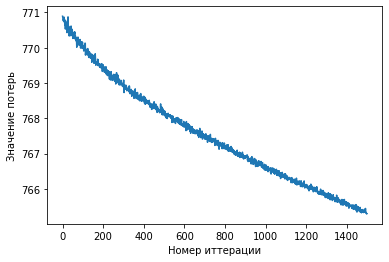

In [80]:
# Построим график потерь от номера иттерации.
plt.plot(loss_hist)
plt.xlabel('Номер иттерации')
plt.ylabel('Значение потерь')
plt.show()

In [81]:
y_train_pred = svm.predict(X_train)
print('Точность при обучении: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('Точность при проверке: %f' % (np.mean(y_val == y_val_pred), ))

Точность при обучении: 0.190878
Точность при проверке: 0.197000


### Перекрестная проверка

Используйте проверочную выборку для корректировки гиперпараметров (степень решуляризации и скорость обучения). Вы должны поэксперементировать с разными диапазонами этих гиперпараметров. Можно добится точности классификации в 0,39 на проверочной выборке.

In [82]:
# Могут возникать ошибки runtime/overflow во время поиска гиперпараметров.
# Причина в экстремальных значениях и это не ошибка в коде.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# результат это словарь связывающий кортежи (learning_rate, regularization_strength)
# с картежами (training_accuracy, validation_accuracy).
# Точность это доля верно классифицированных изображений.
results = {}

for lr in learning_rates:
    for reg in regularization_strengths:
        k = (lr,reg) #f'lr = {str(lr)} / reg = {str(reg)}'
        results[k] = []


In [84]:
# Задание: Напишите код, который подбирает лучшие значения гиперпараметров, корректируя их на проверочной выборке.
# Для каждой комбинации гиперпараметров обучите классификатор на обучающей выборке,
# рассчитайте его точность на обучающей и проверочной выборках и сохраните результаты в словаре.
# Кроме того, наивысшая точность для проверочной выборки сохраняется в Best_val, а полученный классификатор в best_svm.
# Выбирайте небольшие значения для num_iters чтобы обучение не занимало слишком много времени.
# Увеличивайте его когда уверены в правильности работы кода.

best_val = -1   # Наивысшая точность на данный момент.
best_svm = None # Классификатор с наивысшей точностью.

# ***Начало вашего кода***

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        tr_acc = (np.mean(y_train_pred ==y_train ))
        val_acc = (np.mean(y_val_pred == y_val))
        if val_acc >= best_val:
            best_svm = svm
            best_lr = lr
            best_reg = reg
            best_val = val_acc
        results[(lr, reg)] = tr_acc, val_acc
#pass

# ***Конец вашего кода***
    
# Выведем полученные результаты.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('Скорость обучения %e степень регуляризации %e точность при обучении: %f точность при проверке: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Лучшая точность на проверочной выборке при перекрестной проверке: %f' % best_val)

Скорость обучения 1.000000e-07 степень регуляризации 2.500000e+04 точность при обучении: 0.184163 точность при проверке: 0.202000
Скорость обучения 1.000000e-07 степень регуляризации 5.000000e+04 точность при обучении: 0.190143 точность при проверке: 0.188000
Скорость обучения 5.000000e-05 степень регуляризации 2.500000e+04 точность при обучении: 0.321735 точность при проверке: 0.329000
Скорость обучения 5.000000e-05 степень регуляризации 5.000000e+04 точность при обучении: 0.294204 точность при проверке: 0.297000
Лучшая точность на проверочной выборке при перекрестной проверке: 0.329000


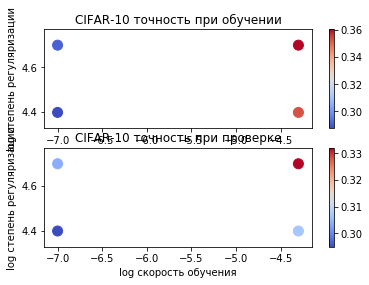

In [73]:
# Визуализируем результаты перекрестной проверки
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Построим график точности на обучающей выборке
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log скорость обучения')
plt.ylabel('log степень регуляризации')
plt.title('CIFAR-10 точность при обучении')

# Построим график точности на проверочной выборке
colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log скорость обучения')
plt.ylabel('log степень регуляризации')
plt.title('CIFAR-10 точность при проверке')
plt.show()

In [74]:
# Оценим лучшую модель на тестовой выборке.
best = best_svm
loss_hist = best.train(X_train, y_train, learning_rate=best_lr, reg=best_reg,
                      num_iters=1500, verbose=False)

y_test_pred = best.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Точность на тестовой выборке: %f' % test_accuracy)

Точность на тестовой выборке: 0.310000


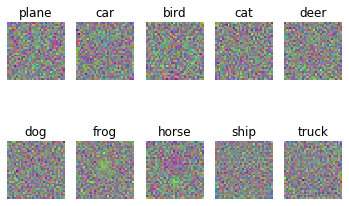

In [75]:
# Визуализируем веса после обучения для каждого класса.
w = best_svm.W[:-1,:]
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])